# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",1000)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all.pkl

rm: cannot remove 'dataset/tf_vae_dense_trained_together_nsl_kdd_all.pkl': No such file or directory


In [3]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [4]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [5]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [6]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.std()

0.99589320646770185

In [7]:
import tensorflow as tf


In [8]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [21]:
import collections
import time
import sklearn.metrics as me 

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)

        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()

            Train.best_acc = 0
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.2)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:1, net.lr:lr})

                        train_batch()
                        count = 10
                        
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                            print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}'
                                                                         .format(h,f)))
                            train_batch()
                            count -= 1

                    valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], #net.summary_op
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})
                    
                    test_accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test, 
                                                                                     net.y_: preprocess.y_test, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    
                    f1_score = me.f1_score(actual_value, pred_value)
                    test_accuracy_, test_loss_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                      net.actual, net.y], #net.summary_op 
                                                                                      feed_dict={net.x: preprocess.x_test_, 
                                                                                     net.y_: preprocess.y_test_, 
                                                                                     net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    #summary_writer_valid.add_summary(summary_str, epoch)

                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(test_accuracy, test_accuracy_))

                    if test_accuracy > Train.best_acc_global:
                        Train.best_acc_global = test_accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        
                        Train.pred_value_ = pred_value_
                        Train.actual_value_ = actual_value_
                        
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if test_accuracy > Train.best_acc:
                        Train.best_acc = test_accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_, "Actual": actual_value_})
                        
                        Train.predictions.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, test_accuracy, f1_score, test_accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epoch+1)*(c+1),f,h):(curr_pred_, 
                                                   Train.result((epoch+1)*(c+1), f, h, valid_accuracy, test_accuracy, f1_score, test_accuracy_, f1_score_, time.perf_counter() - start_time))})
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, test_accuracy))
            print("Best Accuracy on Test data: {}".format(Train.best_acc))
            

In [22]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        
        features_arr = [1, 12, 24, 48, 122]
        hidden_layers_arr = [1, 3]

        Train.predictions = {}
        Train.predictions_ = {}
        Train.results = []

        epochs = [15]
        lrs = [1e-2, 1e-2]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []

        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions_.items():
            dict1_.update({k: v1_})

        Train.predictions = dict1
        Train.predictions_ = dict1_
        
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        
        if not os.path.isfile('dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all.pkl")
            past_scores = past_scores.append(df_results, ignore_index=True)
                
        past_scores.to_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all.pkl")


In [23]:
#%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:15 hidden layers:1 features count:1
Step 1 | Training Loss: 0.000105 | Validation Accuracy: 0.779917
Accuracy on Test data: 0.6815117001533508, 0.5146835446357727
Step 2 | Training Loss: 0.000215 | Validation Accuracy: 0.881524
Accuracy on Test data: 0.761799156665802, 0.5572152137756348
Step 3 | Training Loss: 0.000090 | Validation Accuracy: 0.808533
Accuracy on Test data: 0.7109208703041077, 0.5145147442817688
Step 4 | Training Loss: 0.000043 | Validation Accuracy: 0.788490
Accuracy on Test data: 0.6199432015419006, 0.40708860754966736
Step 5 | Training Loss: 0.000306 | Validation Accuracy: 0.778647
Accuracy on Test data: 0.7403743863105774, 0.6514768004417419
Step 6 | Training Loss: 0.000425 | Validation Accuracy: 0.824846
Accuracy on Test data: 0.7391323447227478, 0.5559493899345398
Step 7 | Training Loss: 0.000102 | Validation Accuracy: 0.796706
Accuracy on Test data: 0.6808019876480103, 0.4925738275051117
Step 8 | Training Loss: 0.000069 | Valida

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 11 | Training Loss: 0.598608 | Validation Accuracy: 0.539829
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 12 | Training Loss: 1.407515 | Validation Accuracy: 0.533915
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 13 | Training Loss: 0.512440 | Validation Accuracy: 0.533876
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 14 | Training Loss: 0.383999 | Validation Accuracy: 0.529867
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 15 | Training Loss: 0.487952 | Validation Accuracy: 0.530185
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 1 | Training Loss: 0.855318 | Validation Accuracy: 0.534392
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.833317 | Validation Accuracy: 0.530105
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.762139 | Validation Accuracy: 0.533320
Accuracy on Test data: 0.43

Step 13 | Training Loss: 0.649616 | Validation Accuracy: 0.534908
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 14 | Training Loss: 1.372472 | Validation Accuracy: 0.527605
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 15 | Training Loss: 0.521095 | Validation Accuracy: 0.539909
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 1 | Training Loss: 0.282591 | Validation Accuracy: 0.534114
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.567270 | Validation Accuracy: 0.534312
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.391793 | Validation Accuracy: 0.532288
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 4 | Training Loss: 2.305556 | Validation Accuracy: 0.529788
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: 0.192790 | Validation Accuracy: 0.539909
Accuracy on Test data: 0.4307

Step 15 | Training Loss: 1.404501 | Validation Accuracy: 0.535344
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 1 | Training Loss: 0.574517 | Validation Accuracy: 0.539353
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.343881 | Validation Accuracy: 0.535463
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.909692 | Validation Accuracy: 0.534947
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 4 | Training Loss: 0.471563 | Validation Accuracy: 0.532129
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 5 | Training Loss: 0.439323 | Validation Accuracy: 0.535305
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 6 | Training Loss: 0.997143 | Validation Accuracy: 0.534312
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 7 | Training Loss: 1.349683 | Validation Accuracy: 0.534273
Accuracy on Test data: 0.430757

Step 2 | Training Loss: 0.000003 | Validation Accuracy: 0.919548
Accuracy on Test data: 0.8691004514694214, 0.7659915685653687
Step 3 | Training Loss: 0.000047 | Validation Accuracy: 0.873784
Accuracy on Test data: 0.8163591027259827, 0.6986497640609741
Step 4 | Training Loss: 0.000076 | Validation Accuracy: 0.894344
Accuracy on Test data: 0.8423527479171753, 0.7253164649009705
Step 5 | Training Loss: 0.431742 | Validation Accuracy: 0.535582
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 6 | Training Loss: 0.744948 | Validation Accuracy: 0.535622
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 7 | Training Loss: 0.141115 | Validation Accuracy: 0.532288
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 8 | Training Loss: 1.027838 | Validation Accuracy: 0.535305
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 9 | Training Loss: 0.055295 | Validation Accuracy: 0.536892
Accuracy on Test data: 0.4307576417922

Step 5 | Training Loss: 0.228582 | Validation Accuracy: 0.537646
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 6 | Training Loss: 0.063389 | Validation Accuracy: 0.532248
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 7 | Training Loss: 0.499909 | Validation Accuracy: 0.536495
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 8 | Training Loss: 2.939292 | Validation Accuracy: 0.535384
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 9 | Training Loss: 0.613026 | Validation Accuracy: 0.535622
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 10 | Training Loss: 0.745708 | Validation Accuracy: 0.534511
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 11 | Training Loss: 1.526883 | Validation Accuracy: 0.534749
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 12 | Training Loss: 1.543381 | Validation Accuracy: 0.532844
Accuracy on Test data: 0.4307

In [24]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions__.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [26]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_all.pkl")

In [27]:
past_scores.sort_values(by='f1_score',ascending=False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
27,14,122,3,0.891883,0.894784,0.903624,0.817300,0.881402,88.621862
26,12,122,3,0.898154,0.891679,0.903600,0.810295,0.881146,46.063003
15,13,12,3,0.906013,0.885690,0.899103,0.796709,0.874276,40.399515
25,6,122,3,0.886922,0.882541,0.896108,0.803207,0.876783,21.043563
14,9,12,3,0.914507,0.881831,0.892892,0.785907,0.862783,26.981111
17,9,24,3,0.912364,0.879924,0.890303,0.791224,0.864275,27.275330
24,5,122,3,0.907164,0.872294,0.882254,0.770886,0.850306,16.874060
13,6,12,3,0.926890,0.859430,0.868512,0.739241,0.825857,16.922411
23,4,122,3,0.889978,0.857567,0.866069,0.747342,0.831019,12.697839
12,3,12,3,0.937210,0.852732,0.862332,0.731814,0.821921,6.821192


In [28]:
psg = past_scores.sort_values(by='test_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
122            3                 14     0.891883    0.894784  0.903624   
12             3                 13     0.906013    0.885690  0.899103   
24             3                  9     0.912364    0.879924  0.890303   
12             1                  2     0.907561    0.842397  0.851158   
1              3                  7     0.780353    0.774973  0.791757   
               1                 10     0.848502    0.763130  0.754911   
24             1                  2     0.889303    0.751419  0.730136   
48             3                  9     0.845009    0.748492  0.731991   
122            1                  2     0.753403    0.565295  0.383027   
48             1                  2     0.532884    0.430758  0.000000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
122            3                   0.817300     0.881402   88.621862  
12             3                   0.796709     0.874276   40.399515  
24             3                   0.791224     0.864275   27.275330  
12             1                   0.710802     0.804874    1.861382  
1              3                   0.708861     0.805371   19.076372  
               1                   0.604726     0.699320   14.574448  
24             1                   0.534262     0.619615    1.909114  
48             3                   0.566920     0.651453   28.795720  
122            1                   0.232911     0.120209    2.686282  
48             1                   0.181603     0.000000    2.086767

In [29]:
psg.mean().sort_values(by='test_score', ascending=False)

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
24             3              5.500000     0.888212    0.856791  0.866555   
12             3              6.600000     0.909030    0.854090  0.862408   
122            3              6.571429     0.899181    0.847543  0.851884   
12             1              2.000000     0.907561    0.842397  0.851158   
24             1              2.000000     0.889303    0.751419  0.730136   
1              1              5.000000     0.836647    0.735480  0.725487   
               3              4.500000     0.738391    0.725193  0.734344   
48             3              6.333333     0.843223    0.725130  0.701916   
122            1              2.000000     0.753403    0.565295  0.383027   
48             1              2.000000     0.532884    0.430758  0.000000   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
24             3                   0.761772     0.842167   15.370342  
12             3                   0.742127     0.828165   18.909530  
122            3                   0.736227     0.815100   28.293461  
12             1                   0.710802     0.804874    1.861382  
24             1                   0.534262     0.619615    1.909114  
1              1                   0.558875     0.653316    6.544023  
               3                   0.654620     0.758435   11.164242  
48             3                   0.536512     0.617201   19.225556  
122            1                   0.232911     0.120209    2.686282  
48             1                   0.181603     0.000000    2.086767

In [30]:
Train.predictions = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
Train.predictions_ = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions__.pkl")

In [36]:
#epoch_nof_hidden
Train.predictions["14_122_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
16476,0.0,1.0,3.718943e-13,0.0


In [37]:
Train.predictions_["14_122_3"].sample()

,Actual,Attack_prob,Normal_prob,Prediction
11510,1.0,1.0,1.180671e-10,0.0


In [38]:
df = Train.predictions["14_122_3"].dropna()
df_ = Train.predictions_["14_122_3"].dropna()

In [39]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}


In [40]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test+"})
score_df = pd.DataFrame(scores, index=[0])

scores = get_score(df_.loc[:,'Actual'].values.astype(int),
                df_.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train+/Test-"})

score_df = score_df.append(pd.DataFrame(scores, index=[1]))

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.894784,0.903624,0.944053,0.866516,Train+/Test+
1,0.817300,0.881402,0.940166,0.829552,Train+/Test-


In [41]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     9711
1.0    12833
Name: Actual, dtype: int64

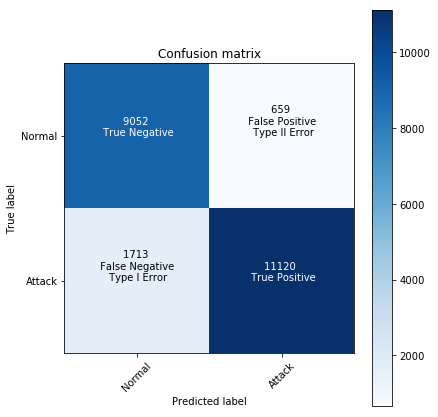

In [42]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [43]:
df_.groupby(by="Actual").Actual.count()

Actual
0.0    2152
1.0    9698
Name: Actual, dtype: int64

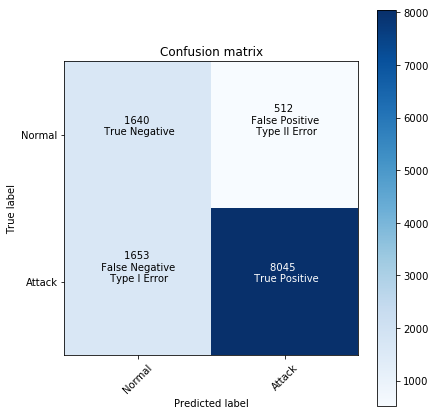

In [44]:
plot(actual_value = df_.loc[:,'Actual'].values.astype(int),
     pred_value = df_.loc[:,'Prediction'].values.astype(int))

In [45]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)

no_of_features  hidden_layers
1               1                  (0.64825565032, 0.80271747066)
                3                 (0.65008285401, 0.818604779719)
12              1                                      (nan, nan)
                3                (0.776571777742, 0.948245001786)
24              1                                      (nan, nan)
                3                 (0.80073006819, 0.932379483883)
48              1                                      (nan, nan)
                3                (0.648904848451, 0.754927695761)
122             1                                      (nan, nan)
                3                 (0.70535682815, 0.998411116676)
dtype: object